In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hiucaominh","key":"ab6907a5d3d9acd2dd8394d44de6f5c5"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tgs-salt-identification-challenge

 24% 9.00M/37.9M [00:01<00:02, 11.9MB/s]
100% 37.9M/37.9M [00:01<00:00, 32.7MB/s]
 96% 207M/217M [00:01<00:00, 198MB/s]
100% 217M/217M [00:01<00:00, 211MB/s]
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 106MB/s]
 77% 32.0M/41.4M [00:00<00:00, 35.4MB/s]
100% 41.4M/41.4M [00:00<00:00, 77.7MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 130MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 84.1MB/s]
 99% 161M/163M [00:01<00:00, 138MB/s]
100% 163M/163M [00:01<00:00, 153MB/s]


In [ ]:
!unzip train.zip -d train
!unzip test.zip -d test

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: test/images/a3df74dd31.png  
  inflating: test/images/187ecc32d5.png  
  inflating: test/images/54538419f5.png  
  inflating: test/images/93614d4b95.png  
  inflating: test/images/50a91adce8.png  
  inflating: test/images/97d23cea10.png  
  inflating: test/images/ca04c19c0b.png  
  inflating: test/images/d168218bac.png  
  inflating: test/images/a670e833a4.png  
  inflating: test/images/a964a0f499.png  
  inflating: test/images/371bf59030.png  
  inflating: test/images/fc74f77bae.png  
  inflating: test/images/f63dc1e3be.png  
  inflating: test/images/b807539a5f.png  
  inflating: test/images/1dfcbf4bca.png  
  inflating: test/images/a971d2ae53.png  
  inflating: test/images/4ad823e2d3.png  
  inflating: test/images/85a9687a4f.png  
  inflating: test/images/da5b430ecd.png  
  inflating: test/images/b1a2903d1c.png  
  inflating: test/images/70958cacd4.png  
  inflating: test/images/2093e5c98e.png  
  inflating: test/i

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from skimage.transform import resize

from tqdm import tqdm_notebook
from tqdm.auto import trange, tqdm

import tensorflow as tf
# from tensorflow import keras
from keras.layers import Layer, Input, Activation
from keras import backend as K
from keras import utils
from keras.models import Model, load_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

In [ ]:
data_dir = '/content'
print('Number images in train data: ', len(os.listdir(data_dir + '/train/images')))
print('Number maskes in train data: ', len(os.listdir(data_dir + '/train/masks')))
print('Number images in test data: ', len(os.listdir(data_dir + '/test/images')))

Number images in train data:  4000
Number maskes in train data:  4000
Number images in test data:  18000


In [ ]:
train_mask = pd.read_csv('/content/train.csv')
depth = pd.read_csv('/content/depths.csv')
train_path = "./"
file_list = list(train_mask['id'].values)
len(file_list)

4000

In [ ]:
X = np.zeros((len(file_list), 128, 128, 1), dtype=np.float32)
y = np.zeros((len(file_list), 128, 128, 1), dtype=np.float32)

for n, id_ in tqdm_notebook(enumerate(train_mask['id']), total=len(file_list)):
    img = load_img("/content/train/images/" + id_ + '.png', grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/train/masks/" + id_ + '.png', grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/65535.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
X_train = X[:int(0.85*len(X))]
y_train = y[:int(0.85*len(X))]
X_val  = X[int(0.85*len(X)):]
y_val  = y[int(0.85*len(X)):]

X_train = np.append(X_train, [np.fliplr(x) for x in X], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y], axis=0)
X_train = np.append(X_train, [np.flipud(x) for x in X], axis=0)
y_train = np.append(y_train, [np.flipud(x) for x in y], axis=0)

print('X train shape:', X_train.shape, 'X val shape:', X_val.shape)
print('Y train shape:', y_train.shape, 'y val shape:', y_val.shape)

X train shape: (11400, 128, 128, 1) X val shape: (600, 128, 128, 1)
Y train shape: (11400, 128, 128, 1) y val shape: (600, 128, 128, 1)


8208


Text(0.5, 1.0, 'Salt')

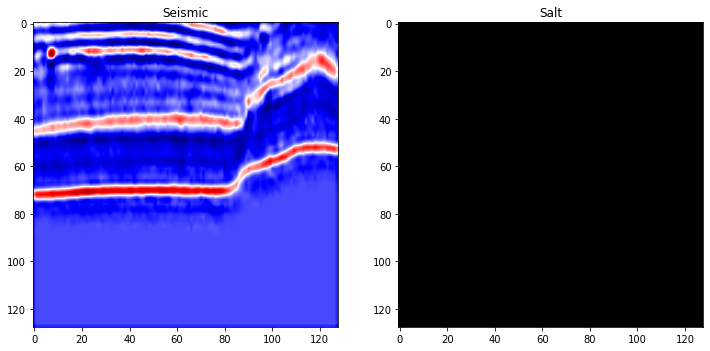

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
print(ix)
has_mask = y_train[ix].max() > 0 # salt indicator

fig, ax = plt.subplots(1, 2, figsize = (12, 8))

ax[0].imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax[0].contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax[1].set_title('Salt')

# **Model**

## **Loss function and Metric**

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [ ]:
def mIOU(y_true, y_pred):
    ulabels = tf.unique(y_true)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (y_true == u) & (y_pred==u)
        union = (y_true == u) | (y_pred==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

In [ ]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
def evaluaWithVal(mod):
    preds_eval = mod.predict(X_val, verbose=1)
    preds_eval = tf.expand_dims(y_pred, axis=-1)
    preds_eval = preds_eval[0]
    thresholds = np.linspace(0, 1, 50)
    ious = np.array([iou_metric_batch(y_val, np.int32(preds_eval > threshold)) for threshold in tqdm(thresholds)])

    threshold_best_index = np.argmax(ious[9:-10]) + 9
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend();

    return threshold_best

## **Model**

### **Basic SegNet**

In [ ]:
def conv_block_encoder(tensor, n_filter, kernel_size = 3, drop= 0.2):
    # Conv layer 1
    enconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same', )(tensor)
    enconv = BatchNormalization()(enconv)
    enconv = Activation('relu')(enconv)
    # Conv layer 2
    enconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(enconv)
    enconv = BatchNormalization()(enconv)
    enconv = Activation('relu')(enconv)
    # Pooling layer
    enconv = MaxPooling2D((2, 2))(enconv)
    enconv = Dropout(drop)(enconv)
    
    return enconv
    
def conv_block_decoder(tensor, n_filter, kernel_size = 3, drop= 0.2):
    # Upsampling layer
    deconv = UpSampling2D((2, 2))(tensor)
    # Conv layer 1
    deconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same', )(deconv)
    deconv = BatchNormalization()(deconv)
    deconv = Activation('relu')(deconv)
    # Conv layer 2
    deconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(deconv)
    deconv = BatchNormalization()(deconv)
    deconv = Activation('relu')(deconv)

    return deconv

def SegNetv1(img_size):
    # Encoder
    enconv1 = conv_block_encoder(img_size, 16, 3, 0.2)
    enconv2 = conv_block_encoder(enconv1, 32, 3, 0.2)
    enconv3 = conv_block_encoder(enconv2, 64, 3, 0.2)
    enconv4 = conv_block_encoder(enconv3, 128, 3, 0.2)
    enconv5 = conv_block_encoder(enconv4, 256, 3, 0.2)

    # Decoder
    deconv1 = conv_block_decoder(enconv5, 256, 3, 0.2)
    deconv2 = conv_block_decoder(deconv1, 128, 3, 0.2)
    deconv3 = conv_block_decoder(deconv2, 64, 3, 0.2)
    deconv4 = conv_block_decoder(deconv3, 32, 3, 0.2)
    deconv5 = conv_block_decoder(deconv4, 16, 3, 0.2)

    # Softmax layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(deconv5)
    model = Model(inputs=[img_size], outputs=[outputs])

    return model

In [ ]:
input_img = Input((128, 128, 1), name='img')
out = SegNetv1(input_img)
out.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_109 (Bat (None, 128, 128, 16)      64        
_________________________________________________________________
activation_108 (Activation)  (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_110 (Bat (None, 128, 128, 16)      64        
_________________________________________________________________
activation_109 (Activation)  (None, 128, 128, 16)      0   

In [ ]:
# utils.plot_model(out, expand_nested=True, show_shapes=True)

In [ ]:
input_img = Input((128, 128, 1), name='img')
segv1model = SegNetv1(input_img)
segv1model.compile(optimizer= Adam(learning_rate= 0.05), loss= binary_crossentropy, metrics= [dice_coefficient])

In [ ]:
callbacks = [
    EarlyStopping(patience=25, verbose=1),
    ReduceLROnPlateau(mode='max',factor=0.3, patience=7, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = segv1model.fit(X_train, y_train, batch_size= 32, epochs=125, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

Epoch 1/125
357/357 [==============================] - 30s 84ms/step - loss: 0.2533 - dice_coefficient: 0.6929 - val_loss: 0.4388 - val_dice_coefficient: 0.5250

Epoch 00001: val_loss improved from inf to 0.43883, saving model to model-tgs-salt.h5
Epoch 2/125
357/357 [==============================] - 29s 82ms/step - loss: 0.2349 - dice_coefficient: 0.7161 - val_loss: 0.5602 - val_dice_coefficient: 0.7075

Epoch 00002: val_loss did not improve from 0.43883
Epoch 3/125
357/357 [==============================] - 29s 82ms/step - loss: 0.2204 - dice_coefficient: 0.7341 - val_loss: 0.3250 - val_dice_coefficient: 0.7404

Epoch 00003: val_loss improved from 0.43883 to 0.32504, saving model to model-tgs-salt.h5
Epoch 4/125
357/357 [==============================] - 29s 82ms/step - loss: 0.2103 - dice_coefficient: 0.7435 - val_loss: 0.2601 - val_dice_coefficient: 0.7724

Epoch 00004: val_loss improved from 0.32504 to 0.26007, saving model to model-tgs-salt.h5
Epoch 5/125
357/357 [==============

19/19 [==============================] - 1s 40ms/step


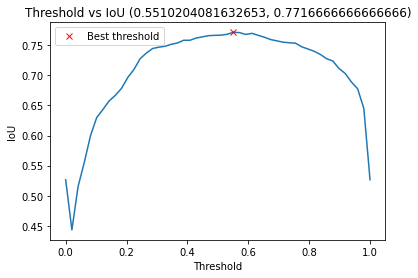

In [ ]:
threshold_best = evaluaWithVal(segv1model)

### **SegNetv2**

In [ ]:
def conv_block_encoder(tensor, n_filter, kernel_size = 3, drop= 0.2):
    # Conv layer 1
    enconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same', )(tensor)
    enconv = BatchNormalization()(enconv)
    enconv = Activation('relu')(enconv)
    # Conv layer 2
    enconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(enconv)
    enconv = BatchNormalization()(enconv)
    enconv = Activation('relu')(enconv)
    # Pooling layer
    enconv = MaxPooling2D((2, 2))(enconv)
    enconv = Dropout(drop)(enconv)
    
    return enconv
    
def conv_block_decoder(tensor, n_filter, kernel_size = 3, drop= 0.2):
    # Upsampling layer
    deconv = UpSampling2D((2, 2), interpolation= 'bilinear')(tensor)
    # Conv layer 1
    deconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same', )(deconv)
    deconv = BatchNormalization()(deconv)
    deconv = Activation('relu')(deconv)
    # Conv layer 2
    deconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(deconv)
    deconv = BatchNormalization()(deconv)
    deconv = Activation('relu')(deconv)

    return deconv

In [ ]:
def SegNetv2(img_size):
    # Encoder
    enconv1 = conv_block_encoder(img_size, 16, 3, 0.2)
    enconv2 = conv_block_encoder(enconv1, 32, 3, 0.2)
    enconv3 = conv_block_encoder(enconv2, 64, 3, 0.2)
    enconv4 = conv_block_encoder(enconv3, 128, 3, 0.2)
    enconv5 = conv_block_encoder(enconv4, 256, 3, 0.2)

    # Decoder
    deconv1 = conv_block_decoder(enconv5, 256, 3, 0.2)
    deconv2 = conv_block_decoder(deconv1, 128, 3, 0.2)
    deconv3 = conv_block_decoder(deconv2, 64, 3, 0.2)
    deconv4 = conv_block_decoder(deconv3, 32, 3, 0.2)
    deconv5 = conv_block_decoder(deconv4, 16, 3, 0.2)

    # Softmax layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(deconv5)
    model = Model(inputs=[img_size], outputs=[outputs])

    return model

In [ ]:
input_img = Input((128, 128, 1), name='img')
segv2model = SegNetv2(input_img)
segv2model.compile(optimizer= Adam(learning_rate= 0.05), loss= binary_crossentropy, metrics= [dice_coefficient])

NameError: ignored

In [ ]:
callbacks = [
    EarlyStopping(patience=17, verbose=1),
    ReduceLROnPlateau(mode='max',factor=0.3, patience=7, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = segv2model.fit(X_train, y_train, batch_size= 32, epochs=75, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

In [ ]:
threshold_best_2 = evaluaWithVal(segv2model)

In [ ]:
transmodel = SegNetv2(input_img)
transmodel.compile(optimizer= Adam(learning_rate= 0.05), loss= loss, metrics= [dice_coefficient])

In [ ]:
transmodel.load_weights('/content/model-tgs-salt.h5')

In [ ]:
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(mode='max',factor=0.2, patience=7, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = transmodel.fit(X_train, y_train, batch_size= 32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

### **SegNetv3**

In [ ]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, *pool_size, 1]
        padding = padding.upper()
        strides = [1, *strides, 1]
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=ksize,
            strides=strides,
            padding=padding)

        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        mask = K.cast(mask, 'int32')
        input_shape = tf.shape(updates, out_type='int32')

        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1] * self.pool_size[0],
                input_shape[2] * self.pool_size[1],
                input_shape[3])

        ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                            K.flatten(updates),
                            [K.prod(output_shape)])

        input_shape = updates.shape
        out_shape = [-1,
                     input_shape[1] * self.pool_size[0],
                     input_shape[2] * self.pool_size[1],
                     input_shape[3]]
        return K.reshape(ret, out_shape)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.pool_size[0],
            mask_shape[2] * self.pool_size[1],
            mask_shape[3]
        )

In [ ]:
def conv_block_encoder(tensor, n_filter, kernel_size = 3):
    # Conv layer 1
    enconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same', kernel_initializer='he_normal')(tensor)
    enconv = BatchNormalization()(enconv)
    enconv = Activation('relu')(enconv)
    # # Conv layer 2
    # enconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(enconv)
    # enconv = BatchNormalization()(enconv)
    # enconv = Activation('relu')(enconv)
    # Pooling layer
    pool, mask = MaxPoolingWithArgmax2D(pool_size=(2, 2))(enconv)
    # enconv = Dropout(drop)(enconv)
    
    return pool, mask
    
def conv_block_decoder(tensor_in, tensor_concat, n_filter, kernel_size = 3):
    # Upsampling layer
    deconv = MaxUnpooling2D(size= (2, 2))([tensor_in, tensor_concat])
    # Conv layer 1 
    deconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same', kernel_initializer= 'he_normal')(deconv)
    deconv = BatchNormalization()(deconv)
    deconv = Activation('relu')(deconv)
    # # Conv layer 2
    # deconv = Conv2D(n_filter, kernel_size= (kernel_size, kernel_size), padding= 'same')(deconv)
    # deconv = BatchNormalization()(deconv)
    # deconv = Activation('relu')(deconv)

    return deconv

In [ ]:
from keras.layers.convolutional import Convolution2D
def SegNetv3(img_size):
    kernel = 3
    pool_size = (2, 2)
    # # Encoder
    # pool1, mask1 = conv_block_encoder(img_size, 32, 3)  # 64*64*16
    # pool2, mask2 = conv_block_encoder(pool1, 64, 3)     # 32*32*32
    # pool3, mask3 = conv_block_encoder(pool2, 64, 3)     # 16*16*64
    # pool4, mask4 = conv_block_encoder(pool3, 128, 3)    # 8*8*128
    # # pool5, mask5 = conv_block_encoder(pool4, 256, 3)    # 4*4*256

    # # Decoder
    # deconv1 = conv_block_decoder(pool4, mask4, 64, 3)  # 8*8*256
    # deconv2 = conv_block_decoder(deconv1, mask3, 64, 3)
    # deconv3 = conv_block_decoder(deconv2, mask2, 32, 3)
    # deconv4 = conv_block_decoder(deconv3, mask1, 2, 3)
    # # deconv5 = conv_block_decoder(deconv4, mask1, 8, 3)

    # # Softmax layer
    # outputs = Conv2D(1, (1, 1), activation='sigmoid')(deconv4)
    # model = Model(inputs=[img_size], outputs=[outputs])
    conv_1 = Convolution2D(32, (kernel, kernel), padding="same")(img_size)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(32, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(64, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(64, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(128, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(128, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(128, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(256, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(256, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(256, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(256, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(256, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(256, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(256, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(256, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(256, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(128, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(128, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(64, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(32, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(16, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(1, (1, 1), padding="same")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    outputs = Activation('softmax')(conv_26)
    model = Model(inputs=[img_size], outputs=[outputs])
    return model

In [ ]:
input_img =Input((128, 128, 1))
out = SegNetv3(input_img)
# utils.plot_model(out, expand_nested=True, show_shapes=True)


Build enceder done..


In [ ]:
input_img = Input((128, 128, 1), name='img')
segv3model = SegNetv3(input_img)
segv3model.compile(optimizer= Adam(learning_rate= 0.05), loss= binary_crossentropy, metrics= [dice_coefficient])

Build enceder done..


In [ ]:
callbacks = [
    EarlyStopping(patience=25, verbose=1),
    ReduceLROnPlateau(mode='max',factor=0.3, patience=7, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = segv3model.fit(X_train, y_train, batch_size= 32, epochs=125, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

Epoch 1/125
357/357 [==============================] - 104s 282ms/step - loss: 0.5768 - dice_coefficient: 0.3868 - val_loss: 0.5689 - val_dice_coefficient: 0.4043

Epoch 00001: val_loss improved from 0.56893 to 0.56892, saving model to model-tgs-salt.h5
Epoch 2/125
 99/357 [=======>......................] - ETA: 1:10 - loss: 0.5622 - dice_coefficient: 0.3949

KeyboardInterrupt: ignored

In [ ]:
threshold_best_3 = evaluaWithVal(segv3model)

### **SiNet**

In [ ]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from keras.layers import (
    Conv2D, BatchNormalization, Dense, 
    ZeroPadding2D, Activation, GlobalAveragePooling2D,
    Reshape, Permute, multiply, AveragePooling2D,
    UpSampling2D, Concatenate, Add, Lambda, Multiply
)
from keras.models import Model, Sequential
from keras.layers import Input
import keras.backend as K
from keras.layers import DepthwiseConv2D, PReLU

import cv2
from glob import glob
import pandas as pd
from sklearn.utils import shuffle
import imgaug as ia
from imgaug import augmenters as iaa

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, BaseLogger

from keras.regularizers import l2
from keras.utils import plot_model

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNEL = 1
CLASSES = ["IsSalt", "NotSalt"]
N_CLASSES = 2
IMAGE_DATA_FORMAT = K.image_data_format()

In [ ]:
class SiNet:
    def __init__(self, img_height, img_width, img_channel, n_classes, reg=1e-4):
        self.img_height = img_height
        self.img_width = img_width
        self.img_channel = img_channel
        self.n_classes = n_classes
        self.reg = reg
        self.channel_axis = 1 if K.image_data_format() == "channels_first" else -1
        self.alpha = 1.0
        self.image_val = 0.017
        self.mean_substraction = [103.94, 116.78, 123.68]
        
    def relu6(self, x):
        return K.relu(x, max_value=6)
    
    def _conv_block(self, inputs, filters, alpha, strides=(1,1), kernel=(3,3), block_id=1, padding="valid"):
        """"""
        filters = int(filters * alpha)
        
        if padding=="same":
            x = inputs
        else:
            x = ZeroPadding2D((1, 1), data_format=IMAGE_DATA_FORMAT, 
                              name="conv_%s_pad" % block_id)(inputs)        
        
        x = Conv2D(filters, kernel, data_format=IMAGE_DATA_FORMAT, 
                   padding=padding, use_bias=False, strides=strides, 
                   kernel_initializer="he_normal", kernel_regularizer=l2(self.reg), 
                   name="conv_%s" % block_id)(x)
        x = BatchNormalization(axis=self.channel_axis, name="conv_%s_bn" % block_id)(x)
        x = Activation("relu", name="conv_%s_act" % block_id)(x)
        
        return x
    
    def _pointwise_conv_block(self, inputs, pointwise_conv_filters, alpha, 
                              strides=(1, 1), block_id=1):
        x = Conv2D(pointwise_conv_filters, 
                   (1, 1),
                   data_format=IMAGE_DATA_FORMAT,
                   padding="same",
                   use_bias=False,
                   strides=(1, 1),
                   kernel_initializer="he_normal",
                   kernel_regularizer=l2(self.reg),
                   name="conv_pw_%s" % block_id)(inputs)
        x = BatchNormalization(axis=self.channel_axis,
                               name="conv_pw_%s_bn" % block_id)(x)
        x = Activation("relu", name="conv_pw_%s_relu" % block_id)(x)
        
        return x
        
    def _depthwise_conv_block(self, inputs, pointwise_conv_filters, alpha, 
                              depth_multiplier=1, strides=(1, 1), block_id=1, 
                              kernel=(3,3), padding_size=(1, 1)):
        """"""
        pointwise_conv_filters = int(pointwise_conv_filters * alpha)
        
        x = ZeroPadding2D(padding_size, 
                          data_format=IMAGE_DATA_FORMAT,
                          name="conv_pad_%s" % block_id)(inputs)
        x = DepthwiseConv2D(kernel_size=kernel,
                            data_format=IMAGE_DATA_FORMAT,
                            depth_multiplier=depth_multiplier,
                            strides=strides,
                            use_bias=False,
                            depthwise_regularizer=l2(self.reg),
                            name="conv_dw_%s" % block_id)(x)
        x = BatchNormalization(axis=self.channel_axis,
                               name="conv_dw_%s_bn" % block_id)(x)
#         x = Activation("PReLu", name="conv_dw_%d_Prelu" % block_id)(x)
        x = PReLU(name="conv_dw_%s_Prelu" % block_id)(x)
        
        x = self._pointwise_conv_block(x, pointwise_conv_filters, self.alpha, block_id=block_id)
        
        return x
    
    def _squeeze_excite_block(self, inputs, ratio=16, block_id=1):
        """"""
        filters = inputs.shape[self.channel_axis]
        se_shape = (1, 1, filters) if self.channel_axis == -1 else (filters, 1, 1)
        
        se = GlobalAveragePooling2D(name="squeeze_glo_avg_%s" % block_id)(inputs)
        se = Dense(filters // ratio, activation="relu", 
                   kernel_initializer="he_normal",
                   kernel_regularizer=l2(self.reg),
                   use_bias=False, name="squeeze_squ_%s" % block_id)(se)
        se = Dense(filters, activation="relu", 
                   kernel_initializer="he_normal",
                   kernel_regularizer=l2(self.reg),
                   use_bias=False, 
                   name="squeeze_exci_%s" % block_id)(se)
        se = multiply([inputs, se], name="squeeze_scale_%s" % block_id)
        
        return se
    
    def _depthwise_conv_se_block(self, inputs, pointwise_conv_filters, alpha, 
                                 depth_multiplier=1, strides=(2, 2), block_id=1,
                                 kernel=(3,3), ratio=16):
        """
        DS-Conv + SE
        """
        x = self._depthwise_conv_block(inputs, pointwise_conv_filters, alpha, 
                                       block_id=block_id, strides=strides)
#         x = Activation("relu")(x)
        x = self._squeeze_excite_block(x, ratio=ratio, block_id=block_id)
        x = Activation("relu")(x)
        
        return x
    
    def _s2_block(self, inputs, pointwise_conv_filters, alpha, 
                  depth_multiplier=1, strides=(1, 1), block_id=1,
                  kernel=(3,3), pool_size=(1,1), padding_size=(1, 1)):
        x = AveragePooling2D(pool_size=pool_size, strides=(2, 2), 
                             data_format=IMAGE_DATA_FORMAT, padding="same")(inputs)
        x = Activation("relu")(x)
        x = self._depthwise_conv_block(x, pointwise_conv_filters, alpha, 
                                       block_id=block_id, kernel=kernel, 
                                       padding_size=padding_size)
        x = UpSampling2D(size=(2, 2), interpolation="bilinear", name="s2_block_%s" % block_id)(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation("relu")(x)
        
        return x
    
    def _s2_module(self, inputs, pointwise_conv_filters, alpha,
                   depth_multiplier=1, strides=(1, 1), block_id=1,
                   kernel_conv=(3, 3), kernel_ds_1=(3, 3), 
                   kernel_ds_2=(3, 3), pad_ds_1=(1, 1), pad_ds_2=(1, 1),
                   pool_block_1=(1, 1), pool_block_2=(1, 1)):
        """
        The function to build S2 block
        """
        x = self._conv_block(inputs, pointwise_conv_filters, alpha, 
                             kernel=(1, 1), block_id=block_id, padding="same")
        x1 = self._s2_block(x, pointwise_conv_filters, alpha, depth_multiplier=depth_multiplier,
                            strides=strides, kernel=kernel_ds_1, block_id=str(block_id) + "_1",
                            padding_size=pad_ds_1, pool_size=pool_block_1)
    
        x2 = self._s2_block(x, pointwise_conv_filters, alpha, depth_multiplier=depth_multiplier,
                            strides=strides, kernel=kernel_ds_2, block_id=str(block_id) + "_2", 
                            padding_size=pad_ds_2, pool_size=pool_block_2)
        
        x = Concatenate(axis=self.channel_axis)([x1, x2])
        x = Add()([inputs, x])
#         x = BatchNormalization(axis=self.channel_axis)(x)
        x = PReLU()(x)
        
        return x
    
    def build_encoder(self):
        """
        Build encoder function
        """
        
        input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)
        
        if IMAGE_DATA_FORMAT == "channels_first":
            input_shape = (IMG_CHANNEL, IMG_HEIGHT, IMG_WIDTH)
            
        inputs = Input(shape=input_shape)
        
        x = Lambda(lambda z: z[...,::-1], output_shape=input_shape, 
                   name="swap_color_channel")(inputs)
        
        if self.mean_substraction:
            x = Lambda(lambda z: (z - np.array(self.mean_substraction))*self.image_val,
                       output_shape=input_shape,
                       name="mean_substraction_inputs")(x)
#         x = inputs

        x1 = self._conv_block(x, 12, self.alpha, strides=(2, 2), block_id=1)
        x2 = self._depthwise_conv_se_block(x1, 16, self.alpha, block_id=2)
        x3 = self._depthwise_conv_se_block(x2, 48, self.alpha, block_id=3, strides=(1, 1))
        x4 = self._s2_module(x3, 24, self.alpha, block_id=4, kernel_ds_2=(5, 5), pad_ds_2=(2, 2))
        x5 = self._s2_module(x4, 24, self.alpha, block_id=5)
        
        x6 = Concatenate(axis=self.channel_axis, name="concat_2_5")([x2, x5])
        
        x7 = self._depthwise_conv_se_block(x6, 48, self.alpha, block_id=6)
        x8 = self._depthwise_conv_se_block(x7, 96, self.alpha, block_id=7, strides=(1, 1))
        x9 = self._s2_module(x8, 48, self.alpha, block_id=8, kernel_ds_2=(5, 5), pad_ds_2=(2, 2))
        x10 = self._s2_module(x9, 48, self.alpha, block_id=9)
        x11 = self._s2_module(x10, 48, self.alpha, block_id=10, 
                              kernel_ds_1=(5, 5), pad_ds_1=(2, 2),
                              kernel_ds_2=(3, 3), pool_block_2=(2, 2))
        x12 = self._s2_module(x11, 48, self.alpha, block_id=11,
                              kernel_ds_1=(5, 5), pad_ds_1=(2, 2),
                              kernel_ds_2=(3, 3), pool_block_2=(4, 4))
        x13 = self._s2_module(x12, 48, self.alpha, block_id=12)
        x14 = self._s2_module(x13, 48, self.alpha, block_id=13,
                              kernel_ds_1=(5, 5), pad_ds_1=(2, 2),
                              kernel_ds_2=(5, 5), pad_ds_2=(2, 2))
        x15 = self._s2_module(x14, 48, self.alpha, block_id=14,
                              kernel_ds_1=(3, 3), pool_block_1=(2, 2),
                              kernel_ds_2=(3, 3), pool_block_2=(4, 4))
        x16 = self._s2_module(x15, 48, self.alpha, block_id=15,
                              kernel_ds_1=(3, 3), pool_block_1=(1, 1),
                              kernel_ds_2=(5, 5), pad_ds_2=(2, 2), pool_block_2=(2, 2))
        
        x17 = Concatenate(axis=self.channel_axis, name="concat_16_7")([x16, x7])
        x17 = Activation("relu")(x17)
        
        x = self._pointwise_conv_block(x17, N_CLASSES, self.alpha, block_id=16)
#         x8_pws = self._pointwise_conv_block(x8, N_CLASSES, self.alpha, block_id=17)
#         x = Add(name="x8_xlast_adding")([x8_pws, x])
        x = Activation("relu")(x)
#         x = Activation("relu")(x)
        
#         x = Reshape((-1, self.n_classes))(x)
        
#         x = Activation("softmax")(x)
        
#         model = Model(inputs=inputs, outputs=x)
        
        return inputs, x, x8, x5, x1
    
    def build_decoder(self):
        inputs, x, x8, x5, x1 = self.build_encoder()
        
        x = UpSampling2D((2, 2), data_format=IMAGE_DATA_FORMAT, 
                         interpolation="bilinear")(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x_ac = Activation("softmax")(x)
        
        x_blocking = K.max(x_ac, axis=-1, keepdims=True)
        
        x_blocking = Lambda(lambda x: 1 - x, name="information_blocking_decoder")(x_blocking)
        
        x5_pws = self._pointwise_conv_block(x5, self.n_classes, self.alpha, block_id=18)
        
        x_mul = Multiply()([x5_pws, x_blocking])
        x = Activation("relu")(x)
        x = Add()([x_mul, x])
        x = Activation("relu")(x)
        x = UpSampling2D((2, 2), interpolation="bilinear")(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation("relu")(x)
        x = self._conv_block(x, self.n_classes, self.alpha, kernel=(1, 1), padding="same", block_id=19)
#         x1_pws = self._pointwise_conv_block(x1, self.n_classes, self.alpha, block_id=20, strides=(1, 1))
#         x = Add()([x1_pws, x])
#         x = Activation("relu")(x)
        x = UpSampling2D((2, 2), interpolation="bilinear")(x)
        x = BatchNormalization(axis=self.channel_axis)(x)
        x = Activation("relu")(x)
        x = Reshape((-1, self.n_classes))(x)
        x = Activation("softmax")(x)
        
        model = Model(inputs=inputs, outputs=x)
        
        return model

In [ ]:
K.clear_session()
sinet = SiNet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL, N_CLASSES)
model = sinet.build_decoder()

In [ ]:
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
class SINetLoss:
    def __init__(self, lamda=0.9):
        self.lamda = lamda
        
    def gt_dilation(self, y_true):
        y_true = tf.reshape(y_true, (-1, IMG_HEIGHT, IMG_WIDTH, N_CLASSES))
        dilation = tf.nn.max_pool2d(y_true, ksize=(15, 15), strides=1, name='dilation2D', padding="SAME")
        dilation = tf.reshape(dilation, (-1, IMG_HEIGHT*IMG_WIDTH, N_CLASSES))
        
        return dilation
    
    def gt_erosion(self, y_true):
        y_true = tf.reshape(y_true, (-1, IMG_HEIGHT, IMG_WIDTH, N_CLASSES))
        erosion = -tf.nn.max_pool2d(-y_true, ksize=(15, 15), strides=1, name='erosion2D', padding="SAME")
        erosion = tf.reshape(erosion, (-1, IMG_HEIGHT*IMG_WIDTH, N_CLASSES))
        
        return erosion
        
    def log_loss(self, y_true, y_pred):
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return loss
        
    def boundary_loss(self, y_true, y_pred):
        dilation = self.gt_dilation(y_true)
        erosion = self.gt_erosion(y_true)

        boundary = tf.math.subtract(dilation, erosion)
#         boundary = tf.reshape(boundary, (-1, IMG_HEIGHT*IMG_WIDTH, N_CLASSES))
#         assign_indices = tf.count_nonzero(boundary, axis=-1)
#         assign_indices = tf.where(boundary)
#         print(tf.shape(boundary).eval(session=tf.compat.v1.Session()))
#         mask = tf.math.greater(tf.to_float(boundary), tf.constant(0.0))
#         zeros_mask = tf.zeros_like(boundary)
        
#         b_true = tf.where(mask, y_true, zeros_mask)
#         b_pred = tf.where(mask, y_pred, zeros_mask)
        loss = -tf.reduce_sum(boundary * tf.math.log(y_pred), axis=-1)
        
        return loss
    
    def compute_loss(self, y_true, y_pred):
        batch_size = tf.shape(y_pred)[0]
        self.lamda = self.lamda
        log_loss_ = tf.cast(self.log_loss(y_true, y_pred), tf.float32)
        boundary_loss_ = tf.cast(self.boundary_loss(y_true, y_pred), tf.float32)
        total_loss = log_loss_ + self.lamda * boundary_loss_
#         total_loss = tf.cast(total_loss, tf.float32)
        total_loss *= tf.cast(batch_size, tf.float32)
        
        return total_loss

In [ ]:
sinet_loss = SINetLoss().compute_loss

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
swap_color_channel (Lambda)     (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
mean_substraction_inputs (Lambd (None, 128, 128, 3)  0           swap_color_channel[0][0]         
__________________________________________________________________________________________________
conv_1_pad (ZeroPadding2D)      (None, 130, 130, 3)  0           mean_substraction_inputs[0][0]   
______________________________________________________________________________________________

In [ ]:
init_lr = 7.5e-3

opt = Adam(lr=init_lr, decay=2e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07,)

In [ ]:
model.compile(optimizer=opt, loss= binary_crossentropy, metrics=[dice_coefficient])

In [ ]:
import keras.backend as K
import keras.callbacks as cbks

class CustomMetrics(cbks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        for k in logs:
            if k.endswith('boundary_loss'):
                print(logs[k])

In [ ]:
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    ReduceLROnPlateau(mode='max',factor=0.3, patience=7, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size= 32, epochs=5, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

Epoch 1/5


ValueError: ignored

### **U2 Net**

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [ ]:
def REBNCONV(x, out_ch=3, dirate=1):
    #x = ZeroPadding2D((1*dirate,1*dirate))(x)
    x = Conv2D(out_ch, 3, padding='same', dilation_rate = 1*dirate)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    return x

def _upsample_like(src, tar):
    h = int(tar.shape[1]/src.shape[1])
    w = int(tar.shape[2]/src.shape[2])
    src = UpSampling2D((h,w), interpolation='bilinear')(src)
    return src

def RSU7(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)
    
    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x4)

    x5 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x5)

    x6 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x6, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x6],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x5)

    x = REBNCONV(tf.concat([x,x5],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x4)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU6(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x4)

    x5 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x5],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x4)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU5(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x3)

    x4 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x4],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x3)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU4(x, mid_ch=12, out_ch=3):
    
    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x = MaxPool2D(2, 2)(x1)

    x2 = REBNCONV(x, mid_ch, 1)
    x = MaxPool2D(2, 2)(x2)

    x3 = REBNCONV(x, mid_ch, 1)

    x = REBNCONV(x, mid_ch, 2)

    x = REBNCONV(tf.concat([x,x3],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x2)

    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 1)
    x = _upsample_like(x,x1)

    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def RSU4F(x, mid_ch=12, out_ch=3):

    x0 = REBNCONV(x, out_ch, 1)
    
    x1 = REBNCONV(x0, mid_ch, 1)
    x2 = REBNCONV(x1, mid_ch, 2)
    x3 = REBNCONV(x2, mid_ch, 4)
    
    x4 = REBNCONV(x3, mid_ch, 8)
    
    x = REBNCONV(tf.concat([x4,x3],axis=-1), mid_ch, 4)
    x = REBNCONV(tf.concat([x,x2],axis=-1), mid_ch, 2)
    x = REBNCONV(tf.concat([x,x1],axis=-1), out_ch, 1)

    return x + x0

def U2NET(x, out_ch=1):
    
    x1 = RSU7(x, 32, 64)
    x = MaxPool2D(2, 2)(x1)

    x2 = RSU6(x, 32, 128)
    x = MaxPool2D(2, 2)(x2)

    x3 = RSU5(x, 64, 256)
    x = MaxPool2D(2, 2)(x3)

    x4 = RSU4(x, 128, 512)
    x = MaxPool2D(2, 2)(x4)

    x5 = RSU4F(x, 256, 512)
    x = MaxPool2D(2, 2)(x5)

    x6 = RSU4F(x, 256, 512)
    x = _upsample_like(x6,x5)

    #-----------------decoder--------------------#

    x5 = RSU4F(tf.concat([x,x5],axis=-1),256, 512)
    x = _upsample_like(x5,x4)

    x4 = RSU4(tf.concat([x,x4],axis=-1),128, 256)
    x = _upsample_like(x4,x3)

    x3 = RSU5(tf.concat([x,x3],axis=-1),64, 128)
    x = _upsample_like(x3,x2)

    x2 = RSU6(tf.concat([x,x2],axis=-1),32, 64)
    x = _upsample_like(x2,x1)
    
    x1 = RSU7(tf.concat([x,x1],axis=-1),16, 64)

    #Side output
    x = ZeroPadding2D((1,1))(x1) 
    d1 = Conv2D(out_ch, 3)(x)
    d1 = Activation('sigmoid')(d1)
    print('d1 shape: ', d1.shape)
    x = ZeroPadding2D((1,1))(x2) 
    x = Conv2D(out_ch, 3)(x)
    d2 = _upsample_like(x,d1)
    d2 = Activation('sigmoid')(d2)
    print('d2 shape: ', d2.shape)
    x = ZeroPadding2D((1,1))(x3) 
    x = Conv2D(out_ch, 3)(x)
    d3 = _upsample_like(x,d1)
    d3 = Activation('sigmoid')(d3)
    print('d3 shape: ', d3.shape)
    x = ZeroPadding2D((1,1))(x4) 
    x = Conv2D(out_ch, 3)(x)
    d4 = _upsample_like(x,d1)
    d4 = Activation('sigmoid')(d4)
    print('d4 shape: ', d4.shape)
    x = ZeroPadding2D((1,1))(x5) 
    x = Conv2D(out_ch, 3)(x)
    d5 = _upsample_like(x,d1)
    d5 = Activation('sigmoid')(d5)
    print('d5 shape: ', d5.shape)
    x = ZeroPadding2D((1,1))(x6) 
    x = Conv2D(out_ch, 3)(x)
    d6 = _upsample_like(x,d1)
    d6 = Activation('sigmoid')(d6)
    print('d6 shape: ', d6.shape)
    d0 = Conv2D(out_ch, 1)(tf.concat([d1,d2,d3,d4,d5,d6],axis=-1))
    d0 = Activation('sigmoid')(d0)
    print('d0 shape: ', d0.shape)
    dx = Conv2D(out_ch, 1)(tf.concat([d0, d1,d2,d3,d4,d5,d6],axis=-1))
    dx = Activation('sigmoid')(dx)
    print('dx shape: ', dx.shape)
    return dx

def U2NETP(x, out_ch=1):
    
    x1 = RSU7(x, 8, 32)
    x = MaxPool2D(2, 2)(x1)

    x2 = RSU6(x, 8, 64)
    x = MaxPool2D(2, 2)(x2)

    x3 = RSU5(x, 8, 16)
    x = MaxPool2D(2, 2)(x3)

    x4 = RSU4(x, 16, 64)
    x = MaxPool2D(2, 2)(x4)

    x5 = RSU4(x, 8, 32)
    x = MaxPool2D(2, 2)(x5)

    x6 = RSU4F(x, 8, 32)
    x = _upsample_like(x6,x5)

    #---------------decoder--------------------
    x5 = RSU4F(tf.concat([x,x5],axis=-1),8, 64)
    x = _upsample_like(x5,x4)

    x4 = RSU4(tf.concat([x,x4],axis=-1),8, 32)
    x = _upsample_like(x4,x3)

    x3 = RSU5(tf.concat([x,x3],axis=-1),16, 32)
    x = _upsample_like(x3,x2)

    x2 = RSU6(tf.concat([x,x2],axis=-1),16, 64)
    x = _upsample_like(x2,x1)
    
    x1 = RSU7(tf.concat([x,x1],axis=-1),8, 16)

    x = ZeroPadding2D((1,1))(x1) 
    d1 = Conv2D(out_ch, 3)(x)
    d1 = Activation('sigmoid')(d1)

    x = ZeroPadding2D((1,1))(x2) 
    x = Conv2D(out_ch, 3)(x)
    d2 = _upsample_like(x,d1)
    d2 = Activation('sigmoid')(d2)
    
    x = ZeroPadding2D((1,1))(x3) 
    x = Conv2D(out_ch, 3)(x)
    d3 = _upsample_like(x,d1)
    d3 = Activation('sigmoid')(d3)
    
    x = ZeroPadding2D((1,1))(x4) 
    x = Conv2D(out_ch, 3)(x)
    d4 = _upsample_like(x,d1)
    d4 = Activation('sigmoid')(d4)
    
    x = ZeroPadding2D((1,1))(x5) 
    x = Conv2D(out_ch, 3)(x)
    d5 = _upsample_like(x,d1)
    d5 = Activation('sigmoid')(d5)
    
    x = ZeroPadding2D((1,1))(x6) 
    x = Conv2D(out_ch, 3)(x)
    d6 = _upsample_like(x,d1)
    d6 = Activation('sigmoid')(d6)

    d0 = Conv2D(out_ch, 1)(tf.concat([d1,d2,d3,d4,d5,d6],axis=-1))
    d0 = Activation('sigmoid')(d0)
    # print(d0.shape)
    return tf.stack([d0,d1,d2,d3,d4,d5,d6])
    # dx = Conv2D(out_ch, 1)(tf.concat([d0, d1,d2,d3,d4,d5,d6],axis=-1))
    # dx = Activation('sigmoid')(dx)
    # print('dx shape: ', d0.shape)
    # return d0


In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()
def loss(y_true, y_pred):
    y_pred = tf.expand_dims(y_pred, axis=-1)
    loss0 = bce(y_true, y_pred[0])
    loss1 = bce(y_true, y_pred[1])
    loss2 = bce(y_true, y_pred[2])
    loss3 = bce(y_true, y_pred[3])
    loss4 = bce(y_true, y_pred[4])
    loss5 = bce(y_true, y_pred[5])
    loss6 = bce(y_true, y_pred[6])
    return loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

def dice_coefficient_new(y_true, y_pred):
    y_pred = tf.expand_dims(y_pred, axis=-1)
    rel = 0
    numerator = 2 * tf.reduce_sum(y_true * y_pred[0])
    denominator = tf.reduce_sum(y_true + y_pred[0])
    rel += numerator / (denominator + tf.keras.backend.epsilon())
    return rel

In [ ]:
net_input = Input(shape=(128,128,1)) 

model_output = U2NETP(net_input)
print(model_output.shape)
model = Model(inputs = net_input, outputs = model_output)

(7, None, 128, 128, 1)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_238 (Conv2D)             (None, 128, 128, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_224 (BatchN (None, 128, 128, 32) 128         conv2d_238[0][0]                 
__________________________________________________________________________________________________
activation_238 (Activation)     (None, 128, 128, 32) 0           batch_normalization_224[0][0]    
____________________________________________________________________________________________

In [ ]:
# utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
model.compile(optimizer= Adam(learning_rate= 0.05), loss= loss, metrics= [dice_coefficient_new])

In [ ]:
callbacks = [
    EarlyStopping(patience=7, verbose=1),
    ReduceLROnPlateau(monitor= 'val_loss', mode='max',factor=0.3, patience=7, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('model-tgs.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [ ]:
results = model.fit(X_train, y_train, batch_size= 32, epochs=1, callbacks=callbacks,\
                    validation_data=(X_val, y_val))

357/357 [==============================] - 79s 185ms/step - loss: 4.2718 - dice_coefficient_new: 0.2511 - val_loss: 17.7047 - val_dice_coefficient_new: 0.2327

Epoch 00001: val_loss improved from inf to 17.70472, saving model to model-tgs.h5


In [ ]:
X_val.shape

(600, 128, 128, 1)

In [ ]:
600//32

18

In [ ]:
model.predict

<bound method Model.predict of <tensorflow.python.keras.engine.functional.Functional object at 0x7f6151f3d7d0>>

In [ ]:
a = model.predict(X_val)

InvalidArgumentError: ignored

In [ ]:
thres_best = evaluaWithVal(model)

19/19 [==============================] - 3s 59ms/step


InvalidArgumentError: ignored

# **Test set**

In [ ]:
test_dir = os.listdir('/content/test/images')
X_test = np.zeros((len(test_dir), 128, 128, 1), dtype=np.float32)
sizes_test = []

for n, id_ in tqdm_notebook(enumerate(test_dir), total=len(test_dir)):
    img = load_img("/content/test/images/" + id_ , grayscale=True)
    test_img = img_to_array(img)
    sizes_test.append([test_img.shape[0], test_img.shape[1]])
    test_img = resize(test_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    X_test[n] = test_img / 255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
def predictTestSet(mod):
    preds_test = mod.predict(X_test, verbose=1)
    preds_test_upsampled = []
    for i in trange(len(preds_test)):
        preds_test_upsampled.append(resize(
            np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]),  mode='constant', preserve_range=True
        ))
    return preds_test_upsampled

preds_test_upsampled_2 = predictTestSet(model)

563/563 [==============================] - 121s 216ms/step


In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {
    fn[:-4]:RLenc(np.round(preds_test_upsampled_2[i] > thres_best)) 
    for i,fn in tqdm(enumerate(test_dir), total=len(test_dir))
}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id'] 
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')